In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from metpy.calc import dewpoint_from_relative_humidity
from metpy.units import units

import sounding_utils
from importlib import reload

import sys
sys.path.append('../../') # lets us import ptype package from the subdir

import matplotlib as mpl

#import ptype.

In [15]:
!ls /glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/

0000  0200  0400  0600	0800  1000  1200  1400	1600  1800  2000  2200
0100  0300  0500  0700	0900  1100  1300  1500	1700  1900  2100  2300


In [16]:
!ls /glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/rap/20220223/1800

MILES_ptype_rap_2022-02-23_1800_f01.nc	MILES_ptype_rap_2022-02-23_1800_f10.nc
MILES_ptype_rap_2022-02-23_1800_f02.nc	MILES_ptype_rap_2022-02-23_1800_f11.nc
MILES_ptype_rap_2022-02-23_1800_f03.nc	MILES_ptype_rap_2022-02-23_1800_f12.nc
MILES_ptype_rap_2022-02-23_1800_f04.nc	MILES_ptype_rap_2022-02-23_1800_f13.nc
MILES_ptype_rap_2022-02-23_1800_f05.nc	MILES_ptype_rap_2022-02-23_1800_f14.nc
MILES_ptype_rap_2022-02-23_1800_f06.nc	MILES_ptype_rap_2022-02-23_1800_f15.nc
MILES_ptype_rap_2022-02-23_1800_f07.nc	MILES_ptype_rap_2022-02-23_1800_f16.nc
MILES_ptype_rap_2022-02-23_1800_f08.nc	MILES_ptype_rap_2022-02-23_1800_f17.nc
MILES_ptype_rap_2022-02-23_1800_f09.nc	MILES_ptype_rap_2022-02-23_1800_f18.nc


In [44]:
#rap and hrrr have same set of inits
hours = ['0000', '0600', '1200', '1700']

#Gfs hours:
# hours = ['0000', '0600', '1200'] 
# or
# hours = ['0600', '1200', '1800'] 


model = 'rap'
ds_dict = {}

for hour in hours:
    ds = xr.open_mfdataset(f"/glade/campaign/cisl/aiml/ptype/ptype_case_studies/kentucky/{model}/20220223/{hour}/*.nc", concat_dim='time', combine='nested')
    ds.attrs['nwp'] = model
    ds.attrs['init_hr'] = hour
    ds_dict[hour] = ds

    


In [49]:
reload(sounding_utils)

def plot_func(predtype, x_col):
    cm = mpl.colormaps['viridis']
    time = ds_dict['0000'].valid_time.values[-1]

    fig, ax = sounding_utils.skewCompositeFigAx(figsize=(5,5))
    num_inits = len(ds_dict)

    y = ds_dict[list(d.keys())[0]]['heightAboveGround'].values

    for hour, alpha in zip(ds_dict.keys(), np.linspace(0,0.8,num_inits)):
        ds = ds_dict[hour]
        subset = ds.where((ds['crain'] == 1) | (ds['csnow'] == 1) | (ds['cicep'] == 1) | (ds['cfrzr'] == 1))
        subset = subset.where(subset.valid_time == time)
        subset = subset.where(ds[predtype]==1)

        profile = subset[x_col].mean(dim=('x','y','time'))

        num_obs = subset[x_col].count(dim=('x','y','time')).values[0]
        frac_above_zero = frac_abv_zero(subset, x_col, num_obs)

        line, = ax.plot(profile, y, color=cm(alpha), linewidth=2, marker='o')
        line.set_label(f'''{ds.attrs['nwp']} init: {hour}\nnum obs: {num_obs}\nFrac above 0: {frac_above_zero:.2f}''')

    ax.set_title(f'''Mean interp. t_h for {predtype}\nat forecast hour {time}''')
    ax.legend()
    return fig,ax

(<Figure size 500x500 with 1 Axes>,
 <SkewXAxes: title={'center': 'Mean interp. t_h for cfrzr\nat forecast hour 2022-02-23T18:00:00.000000000'}, ylabel='Height above ground (m)'>)

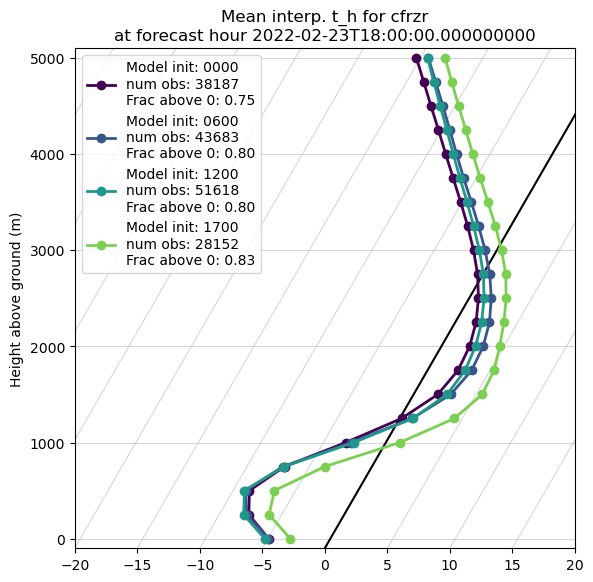

In [50]:
plot_func('cfrzr')

(<Figure size 500x500 with 1 Axes>,
 <SkewXAxes: title={'center': 'Mean interp. t_h for ML_cfrzr\nat forecast hour 2022-02-23T18:00:00.000000000'}, ylabel='Height above ground (m)'>)

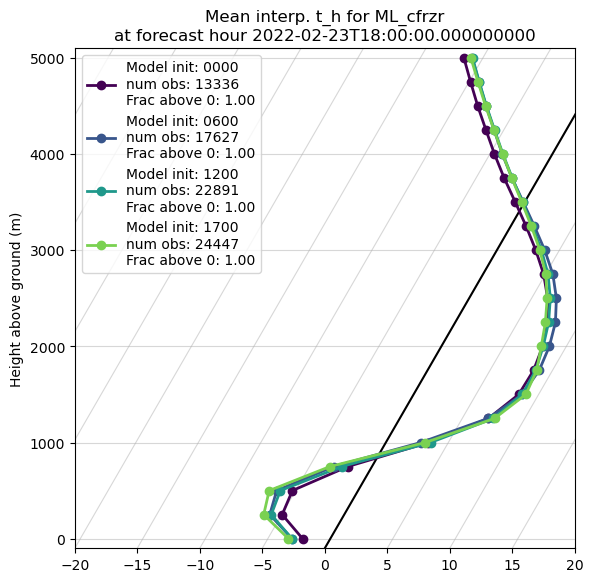

In [51]:
plot_func('ML_cfrzr')

In [52]:
plt.savefig("ML_cfrzr_lead_times.png")

<Figure size 640x480 with 0 Axes>